# <center><div style="color:red">PRE-PROCESSING: SIMPLE DATA</div></center>

### <font color='blue'> Table of Contents </font>
- [1 - Objectives](#1)
- [2 - Setup](#2)
- [3 - Helper Functions](#3)
- [4 - Download Data](#4)
- [5 - Understanding the Data](#5)
- [6 - Image and Mask Pre-processing](#6) <br>
    - [6.1. - Image Pre-processing](#6) <br>
    - [6.2. - Mask Pre-processing](#6) <br>
    - [6.3. - Putting everything together](#6) <br>
- [7 - Creating TF Datasets](#7)
- [8 - References](#references)

<a name="1"></a> 
## <font color="orange"> <b> 1. Introduction </b> </font>

In this notebook, we demonstrate how to perform preprocessing for image segmentation tasks using simple synthetic data. Image segmentation involves classifying each pixel in an image, making preprocessing steps critical for successful training and evaluation of models.

We will:

- Generate synthetic images and corresponding segmentation masks

- Apply common preprocessing techniques such as resizing and normalization.

Prepare the data in a format suitable for training deep learning models

This notebook is ideal for understanding the preprocessing pipeline in a controlled environment before applying it to real-world datasets.

<a name="2"></a> 
## <font color="orange"> <b> 2. Setup </b> </font>

In [14]:
import os
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg

In [5]:
tf.random.set_seed(5)

In [6]:
from dataclasses import dataclass

# for default values
@dataclass
class DataConfig:
    batch_size: int = 32
    width: int = 224
    height: int = 224

G = DataConfig()

<a name="3"></a> 
## <font color="orange"> <b> 3. Synthetic Data Generation for Segmentation </b> </font>

In [7]:
# Output folders
image_dir = "synthetic_dataset/images"
mask_dir = "synthetic_dataset/masks"
os.makedirs(image_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

# Parameters
num_samples = 10
img_size = 128
shape_colors = {
    "square": (255, 0, 0),  # Red
    "circle": (0, 255, 0),  # Green
}

for i in range(num_samples):
    img = np.ones((img_size, img_size, 3), dtype=np.uint8) * 255  # white background
    mask = np.zeros((img_size, img_size), dtype=np.uint8)         # 0=background (background will be class 0)

    shapes = random.choices(["square", "circle"], k=random.randint(1, 2))  # at least 5 shape

    for shape in shapes:
        x, y = random.randint(10, 90), random.randint(10, 90)
        size = random.randint(15, 30)

        if shape == "square":
            cv2.rectangle(img, (x, y), (x+size, y+size), shape_colors["square"], -1)
            cv2.rectangle(mask, (x, y), (x+size, y+size), 1, -1) # square = 1 (square will be class 1)
        elif shape == "circle":
            cv2.circle(img, (x, y), size//2, shape_colors["circle"], -1)
            cv2.circle(mask, (x, y), size//2, 2, -1) # circle will be class 2

    cv2.imwrite(f"{image_dir}/img_{i:03d}.png", img)
    cv2.imwrite(f"{mask_dir}/mask_{i:03d}.png", mask)


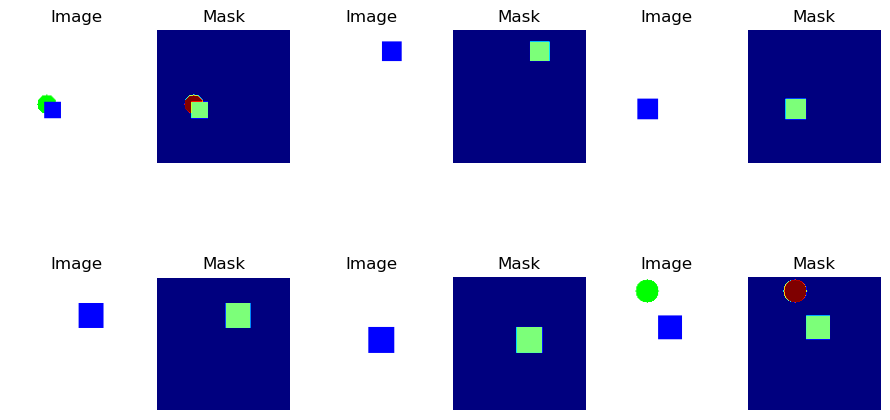

In [8]:
# Directories
image_dir = "synthetic_dataset/images"
mask_dir = "synthetic_dataset/masks"

# Number of samples to plot
num_samples_to_show = 6  # Multiple of 3 for even rows

# Get sample filenames
image_filenames = sorted(os.listdir(image_dir))[:num_samples_to_show]
mask_filenames = sorted(os.listdir(mask_dir))[:num_samples_to_show]

# Plot settings
pairs_per_row = 3
fig, axs = plt.subplots(num_samples_to_show // pairs_per_row, pairs_per_row * 2, figsize=(pairs_per_row * 3, (num_samples_to_show // pairs_per_row) * 3))

for i, (img_file, mask_file) in enumerate(zip(image_filenames, mask_filenames)):
    # Load image and mask
    img = cv2.imread(os.path.join(image_dir, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)

    row = i // pairs_per_row
    col = (i % pairs_per_row) * 2

    axs[row, col].imshow(img)
    axs[row, col].set_title("Image")
    axs[row, col].axis("off")

    axs[row, col + 1].imshow(mask, cmap='jet', vmin=0, vmax=2)
    axs[row, col + 1].set_title("Mask")
    axs[row, col + 1].axis("off")

plt.tight_layout()
plt.show()


In [9]:
!ls synthetic_dataset/images

img_000.png  img_002.png  img_004.png  img_006.png  img_008.png
img_001.png  img_003.png  img_005.png  img_007.png  img_009.png


In [10]:
train_img_dir = "synthetic_dataset/images"
train_annotation_dir = "synthetic_dataset/masks"

In [48]:
classes = ['background', 'square', 'circle']
num_classes = len(classes)

<a name="4"></a> 
## <font color="orange"> <b> 4. Image and Mask Pre-processing </b> </font>

<a name="4.1"></a> 
### <font color="#ca6f1e"> <b> 4.1. Image Pre-processing </b> </font>

We will

- Read the image
- Resize to the desired size.
- Normalize pixel values to [-1, 1]

We will take one image as an example.

In [11]:
img_path = image_dir + "/img_007.png"

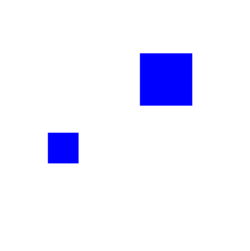

In [15]:
# plot the image
img = mpimg.imread(img_path)

plt.figure(figsize=(3,3))

plt.imshow(img)
plt.axis('off') # Turn off axis labels and ticks
plt.show()

In [16]:
# read image
img_raw = tf.io.read_file(img_path)
type(img_raw)

tensorflow.python.framework.ops.EagerTensor

In [17]:
img_raw

<tf.Tensor: shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x80\x00\x00\x00\x80\x08\x02\x00\x00\x00L\\\xf6\x9c\x00\x00\x02FIDATx\x01\xed\xc11\n\xc3@\x10\x04\xb0\x99\xff?Z\xe9\xdc\x9b\xdc\xb1`V*\xb2\xe6\x14Ys\x8a\xac9E\xd6\x9c"kN\x915\xa7\xc8\x9aSd\xcd)\xb2\xe6\x14Ys\x8a\xac9E\xd6\x9c"kN\x915\xa7\xc8\x9aSd\xcd)\xb2\xe6\x14Ys\x8a\xac9E\xd6\x9c"kN\x915\xa7\xc8\x9aSd\xcd)\xf2Emn g\x15\xf9\xa267\x90\xb3\x8a|Q\x9b\x1b\xc8YE\xbe\xa8\xcd\r\xe4\xac"_\xd4\xe6\x06rV\x91/js\x039\xab\xc8\x17\xb5\xb9\x81\x9cU\xe4\x8b\xda\xdc@\xce*\xf2Emn g\x15\xf9\xa267\x90\xb3\x8a|Q\x9b\x1b\xc8YE\xbe\xa8\xcd\r\xe4\xac"_\xd4\xe6\x06rV\x91/js\x039\xab\xc8\x17\xb5\xb9\x81\x9cU\xe4\x8b\xda\xdc@\xce*\xf2Emn g\x15\xf9\xa267\x90\xb3\x8a|Q\x9b\x1b\xc8YE\xbe\xa8\xcd\r\xe4\xac"_\xd4\xe6\x06rV\x91/js\x039\xab\xc8\x17\xb5\xb9\x81\x9cU\xe4\x8b\xda\xdc@\xce*\xf2Emn g\x15\xf9\xa267\x90\xb3\x8a|Q\x9b\x1b\xc8YE\xbe\xa8\xcd\r\xe4\xac"_\xd4\xe6\x06rV\x915\xa7\xc8\x9aSd\xcd)\xb2\xe6\x14Ys\x8a\xac9E\xd6\

We can see that the image contains binary data. Let's decode it.

In [18]:
image = tf.image.decode_png(img_raw, channels=3)

In [19]:
type(image), image

(tensorflow.python.framework.ops.EagerTensor,
 <tf.Tensor: shape=(128, 128, 3), dtype=uint8, numpy=
 array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 

Now it contains pixel values (between 0 and 255).

Now, let's resize the image to the desired width and height.

In [20]:
image.shape

TensorShape([128, 128, 3])

In [21]:
width = 224
height = 224

image = tf.image.resize(image, (height, width))
image.shape

TensorShape([224, 224, 3])

Finally, let's normalize pixel values to [-1, 1]

In [22]:
image = tf.cast(image, tf.float32) / 127.5 - 1.0

In [23]:
image

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)>

Now the pixel values are between -1 and 1.

<a name="4.2"></a> 
### <font color="#ca6f1e"> <b> 4.2. Mask Pre-processing </b> </font>

It is important to note that the mask is not an image but a label class map.

- In image segmentation tasks, the mask file is usually stored as an image (e.g., PNG), but its content is not a regular RGB image.

- Instead, each pixel value in the mask represents a class label (e.g., 0 = background, 1 = car, 2 = person, etc.).

- So while technically stored as an image, semantically it's a class label map, not visual data.


We will:

- Read the mask.
- Resize to the desire size.
- Apply One-hot encoding.


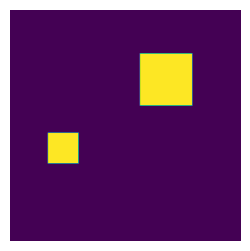

In [27]:
mask_path = mask_dir + "/mask_007.png"

# plot the image
mask = mpimg.imread(mask_path)

plt.figure(figsize=(3,3))

plt.imshow(mask)
plt.axis('off') # Turn off axis labels and ticks
plt.show()

In [29]:
# read the annotation
mask_raw = tf.io.read_file(mask_path)
mask_raw

<tf.Tensor: shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x80\x00\x00\x00\x80\x08\x00\x00\x00\x00\xe6U>\x17\x00\x00\x01mIDATx\x01\xc5\xc11\x0e\x00 \x0c\xc4\xb0\xe4\xff\x8f.;\xa2\x9d\x8a\xce\x960\t\x930\t\x930\t\x930\t\x930\t\x930\t\x930\t\x930\t\x930\t\x930\t\x930\t\x930\t\x93%2(Z\xb2D\x06EK\x96\xc8\xa0h\xc9\x12\x19\x14-Y"\x83\xa2%KdP\xb4d\x89\x0c\x8a\x96,\x91A\xd1\x92%2(Z\xb2D\x06EK\x96\xc8\xa0h\xc9\x12\x19\x14-Y"\x83\xa2%KdP\xb4d\x89\x0c\x8a\x96,\x91A\xd1\x92%2(Z\xb2D\x06EK\x96\xc8\xa0h\xc9\x12\x19\x14-Y"\x83\xa2%KdP\xb4d\x89\x0c\x8a\x96,\x91A\xd1\x92%2(Z\xb2D\x06EK\x96\xc8\xa0h\xc9\x12\x19\x14-Y"\x83\xa2%a\x12&a\x12&a\x12&a\x12&a\x12&a\x12&a\x12&a\xf2"\x97\xe2\x17y\x91K\xf1\x8b\xbc\xc8\xa5\xf8E^\xe4R\xfc"/r)~\x91\x17\xb9\x14\xbf\xc8\x8b\\\x8a_\xe4E.\xc5/\xf2"\x97\xe2\x17y\x91K\xf1\x8b\xbc\xc8\xa5\xf8E^\xe4R\xfc"/r)~\x91\x17\xb9\x14\xbf\xc8\x8b\\\x8a_\xe4E.\xc5/\xf2"\x97\xe2\x17\t\x930\t\x930\t\x930\t\x930\t\x930\t\x930\t\x930\t\x930\t\x930\t\x930\t\

In [30]:
# decode
mask = tf.image.decode_png(mask_raw, channels=1)
mask

<tf.Tensor: shape=(128, 128, 1), dtype=uint8, numpy=
array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)>

It contains integer values between 0 and 1 (0,1 and 2) representing the 3 different classes.

In [31]:
mask.shape

TensorShape([128, 128, 1])

In [32]:
# resize
mask = tf.image.resize(mask, (height, width), method='nearest')  # Keep class labels intact
mask.shape

TensorShape([224, 224, 1])

In [33]:
# cast
mask = tf.cast(mask, tf.int32)
mask.dtype

tf.int32

In [34]:
# Remove channel dimension (H, W, 1) -> (H, W)
mask = tf.squeeze(mask, axis=-1)
mask.shape

TensorShape([224, 224])

In [38]:
# Convert annotation to one-hot format: shape becomes (H, W, num_classes)
mask = tf.one_hot(mask, depth=num_classes)
mask.shape, mask

(TensorShape([224, 224, 3]),
 <tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],
 
        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],
 
        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],
 
        ...,
 
        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],
 
        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],
 
        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0

<a name="4.3"></a> 
### <font color="#ca6f1e"> <b> 4.3. Putting everything together </b> </font>

We can combine image and mask pre-processing in one function.

In [39]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=64, width=64, num_classes=num_classes):
    """
    Reads and preprocesses an image and its corresponding segmentation mask from given file paths.

    Args:
        t_filename (tf.Tensor or str): Path to the input image file.
        a_filename (tf.Tensor or str): Path to the corresponding annotation (mask) file.
        height (int): Target height to resize the image and mask. Defaults to G.height.
        width (int): Target width to resize the image and mask. Defaults to G.width.
        num_classes (int): Number of segmentation classes for one-hot encoding. Defaults to num_classes.

    Returns:
        image (tf.Tensor): Preprocessed image tensor of shape (height, width, 3), normalized to [-1, 1].
        annotation (tf.Tensor): One-hot encoded mask tensor of shape (height, width, num_classes).
    """

    # Read and decode the image (3 channels)
    img_raw = tf.io.read_file(t_filename)
    image = tf.image.decode_png(img_raw, channels=3)
    image = tf.image.resize(image, (height, width))  # Resize image to desired size
    image = tf.cast(image, tf.float32) / 127.5 - 1.0  # Normalize pixel values to [-1, 1]

    # Read and decode the annotation mask (1 channel)
    anno_raw = tf.io.read_file(a_filename)
    annotation = tf.image.decode_png(anno_raw, channels=1)
    annotation = tf.image.resize(annotation, (height, width), method='nearest')  # Keep class labels intact
    annotation = tf.cast(annotation, tf.int32)
    annotation = tf.squeeze(annotation, axis=-1)  # Remove channel dimension (H, W, 1) -> (H, W)

    # Convert annotation to one-hot format: shape becomes (H, W, num_classes)
    annotation = tf.one_hot(annotation, depth=num_classes)

    return image, annotation


<a name="5"></a> 
## <font color="orange"> <b> 5. Creating TF Datasets </b> </font>

First, we need a function that returns sorted file paths for images and their corresponding segmentation masks (label maps). 

In [40]:
def get_dataset_slice_paths(image_dir, label_map_dir):
    '''
    Returns sorted paths to image and mask files.
    '''
    image_file_list = sorted(os.listdir(image_dir))
    label_map_file_list = sorted(os.listdir(label_map_dir))

    image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
    label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]

    return image_paths, label_map_paths

In [41]:
# test it
get_dataset_slice_paths(image_dir, mask_dir)

(['synthetic_dataset/images/img_000.png',
  'synthetic_dataset/images/img_001.png',
  'synthetic_dataset/images/img_002.png',
  'synthetic_dataset/images/img_003.png',
  'synthetic_dataset/images/img_004.png',
  'synthetic_dataset/images/img_005.png',
  'synthetic_dataset/images/img_006.png',
  'synthetic_dataset/images/img_007.png',
  'synthetic_dataset/images/img_008.png',
  'synthetic_dataset/images/img_009.png'],
 ['synthetic_dataset/masks/mask_000.png',
  'synthetic_dataset/masks/mask_001.png',
  'synthetic_dataset/masks/mask_002.png',
  'synthetic_dataset/masks/mask_003.png',
  'synthetic_dataset/masks/mask_004.png',
  'synthetic_dataset/masks/mask_005.png',
  'synthetic_dataset/masks/mask_006.png',
  'synthetic_dataset/masks/mask_007.png',
  'synthetic_dataset/masks/mask_008.png',
  'synthetic_dataset/masks/mask_009.png'])

Finally, we will prepare the TF Datasets.

We will:

-  Creates a TensorFlow dataset from the given lists of file paths.
-  Apply the pre-processing function to every element in the dataset.
-  Shuffle data (only in training)
-  Configure batch size.


In [42]:
# sorted file paths
training_image_paths, training_label_map_paths = get_dataset_slice_paths(image_dir, mask_dir)

# create TF dataset
training_dataset = tf.data.Dataset.from_tensor_slices((training_image_paths, training_label_map_paths ))

# Now each element of training_dataset will be a tuple of two tensors (image_path, mask_path)
for image_path_tensor, mask_path_tensor in training_dataset.take(2):
    print(f"Image Path: {image_path_tensor.numpy()}")
    print(f"Mask Path: {mask_path_tensor.numpy()}")


Image Path: b'synthetic_dataset/images/img_000.png'
Mask Path: b'synthetic_dataset/masks/mask_000.png'
Image Path: b'synthetic_dataset/images/img_001.png'
Mask Path: b'synthetic_dataset/masks/mask_001.png'


In [43]:
# apply the pre-processing function to every element in the dataset
training_dataset = training_dataset.map(map_filename_to_image_and_mask)

for image_path_tensor, mask_path_tensor in training_dataset.take(1):
    print(f"Image: {image_path_tensor.numpy()}")
    print(f"Mask: {mask_path_tensor.numpy()}")

Image: [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
Mask: [[[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  ...
  [1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  ...
  [1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  ...
  [1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 ...

 [[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  ...
  [1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  ...
  [1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [

In [44]:
# shuffle (only for training)
training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)

# configure batch size
training_dataset = training_dataset.batch(32)

Finally, we can combine this in one function.

In [45]:
def get_dataset(image_paths, label_map_paths, batch_size = 8, training=True):
  '''
    Args:
        image_paths (list of str): Paths to each image file in the dataset.
        label_map_paths (list of str): Paths to each label map file.
        batch_size (int): Number of samples per batch.
        training (bool): Whether the dataset is for training (enables shuffling).

    Returns:
        tf.data.Dataset: A dataset yielding batches of preprocessed images and masks.
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  training_dataset = training_dataset.map(map_filename_to_image_and_mask)
  if training:
      training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(batch_size)

  return training_dataset

In [46]:
# get the paths to the images
training_image_paths, training_label_map_paths = get_dataset_slice_paths(train_img_dir, train_annotation_dir)

# generate the train and val sets
training_dataset = get_dataset(training_image_paths, training_label_map_paths)

In [47]:
for image_batch, mask_batch in training_dataset.take(1):
    print(f"Image: {image_batch.shape}") # batch size, width, height, number of channels
    print(f"Mask: {mask_batch.shape}") # batch size, , width, height, num classes (one-hot encoded)

Image: (8, 64, 64, 3)
Mask: (8, 64, 64, 3)


<a name="references"></a> 
## <font color="orange"> <b> References </b> </font>

[TF Advanced Techniques Specialization](https://www.coursera.org/specializations/tensorflow-advanced-techniques)